In [48]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.auto import trange

from rl_env.myenv_redesign import MyEnv
from base_rl_mcmc.distributions import Distribution
from base_rl_mcmc.toolbox import first_nan_position

import toml
from typing import Sequence
from types import SimpleNamespace

config = toml.load("./base_rl_mcmc/config/config_ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, obs: jnp.ndarray):
        obs = obs.reshape(-1, 2)
        x = obs[:, 0:1]
        eps = obs[:, 1:2]

        x_sigma = self.phi(x, name="x_sigma")
        x_1_sigma = x + eps * x_sigma
        x_1_sigma = self.phi(x_1_sigma, name="x_1_sigma")

        return jnp.concatenate([x_sigma, x_1_sigma], -1)

    def phi(self, input, name):
        x = nn.Dense(48, name=f"{name}_dense1")(input)
        x = nn.softplus(x)
        x = nn.Dense(48, name=f"{name}_dense2")(x)
        x = nn.softplus(x)
        x = nn.Dense(self.action_dim, name=f"{name}_dense3")(x)
        x = nn.softplus(x)
        return x

In [3]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [4]:
# Setup env
log_p = Distribution.gaussian1D
dim = 1
max_steps=10_000

env = MyEnv(log_p, dim, max_steps)
max_action = float(env.action_space.high[0])
env.observation_space.dtype = np.float32
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False,
)

In [5]:
# Start
obs, _ = env.reset()

actor = Actor(action_dim=env.dim)
qf1 = QNetwork()

actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
)

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

In [6]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)  # TODO: proper clip
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value


In [30]:
for global_step in trange(args.total_timesteps):

    actions = actor.apply(actor_state.params, obs)
    # actions = np.asarray(actions + np.random.normal(0, args.exploration_noise)).clip(
    #             env.action_space.low, env.action_space.high)

    next_obs, rewards, terminateds, truncateds, infos = env.step(actions.flatten())

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state,
            qf1_state,
            data.observations.numpy(),
            data.actions.numpy(),
            data.next_observations.numpy(),
            data.rewards.flatten().numpy(),
            data.dones.flatten().numpy(),
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state,
                qf1_state,
                data.observations.numpy(),
            )


  0%|          | 0/20000 [00:00<?, ?it/s]

In [51]:
state_list = np.array([i for i in env.store_state])[:, 0]
action_list = np.array([i.squeeze() for i in env.store_action])
reward_list = np.array([i for i in env.store_reward]).flatten()

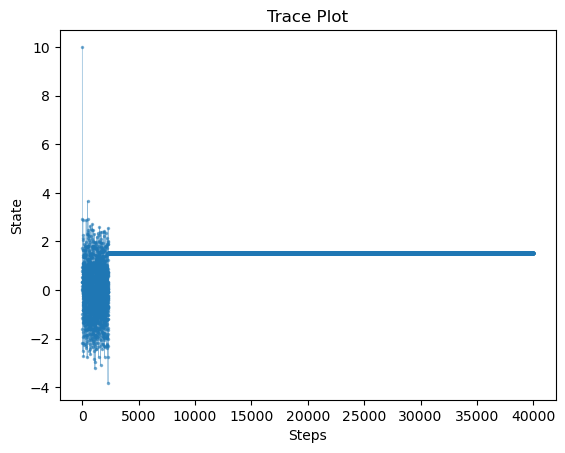

In [32]:
# Trace Plot
plt.plot(state_list, 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot")
plt.xlabel("Steps")
plt.ylabel("State")
plt.show()

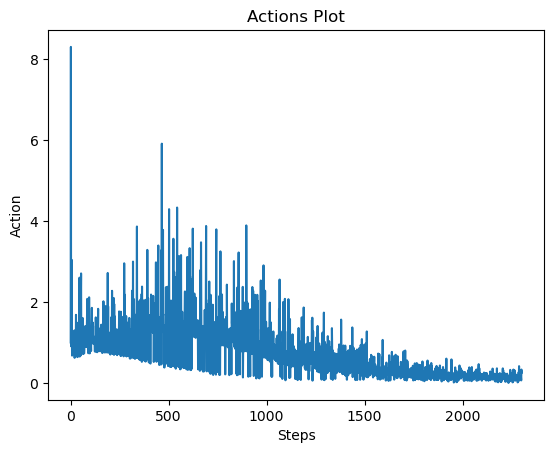

In [52]:
# Action Plot
plt.plot([i.squeeze() for i in env.store_action])
plt.title("Actions Plot")
plt.xlabel("Steps")
plt.ylabel("Action")
plt.show()

In [50]:
first_nan_position(action_list)

2302

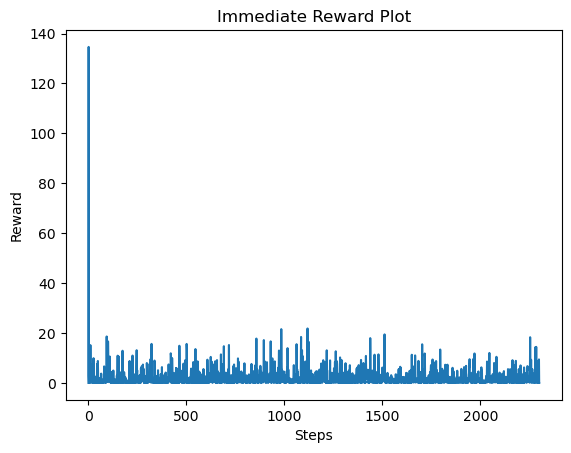

In [53]:
# Immediate Reward Plot
reward_list = np.array([i for i in env.store_reward]).flatten()
plt.plot(reward_list)
plt.title("Immediate Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

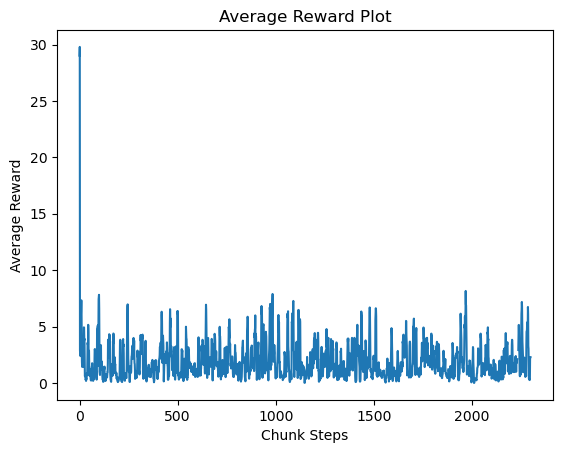

In [54]:
# Average Reward Plot
kernel = np.ones(5) / 5
averages = np.convolve(reward_list, kernel, mode='valid')

plt.plot(averages)
plt.title('Average Reward Plot')
plt.xlabel('Chunk Steps')
plt.ylabel('Average Reward')
plt.show()


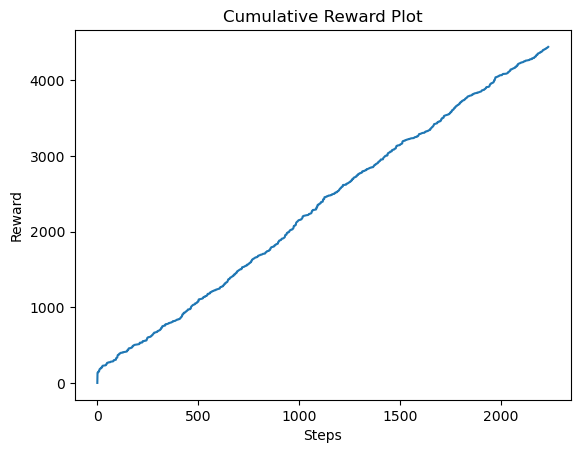

In [55]:
# Cumulative Reward Plot
plt.plot(np.cumsum(reward_list))
plt.title("Cumulative Reward Plot")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

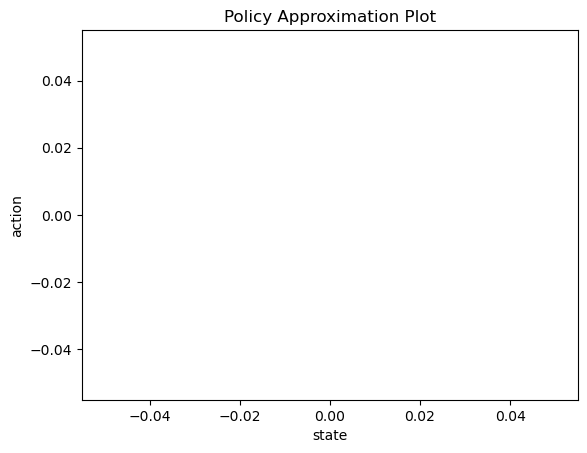

In [58]:
# Policy Plot
x = np.linspace(-10, 10, 1000)
eps = np.random.normal(0, 1, 1000)
obs = np.stack([x, eps], -1)
policy_action = actor.apply(actor_state.params, obs)
plt.plot(x, policy_action)

plt.title('Policy Approximation Plot')
plt.xlabel('state')
plt.ylabel('action')

plt.show()

In [64]:
# Q approximation Plot
a = np.stack([np.linspace(0, 10, 1000), np.linspace(0, 10, 1000)], -1)

Z = qf1.apply(qf1_state.params, obs, a)

In [65]:
X, A = np.meshgrid(x, a)
plt.contourf(X, A, Z.T, 20)
plt.colorbar()

plt.title('Q Approximation Plot')
plt.xlabel('state')
plt.ylabel('action')

plt.show()

Array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [69]:
# ESJD Plot (Monte Carlo)
differences = np.diff(state_list.reshape(-1,1), axis=0)
squared_jump_distances = np.sum(differences**2, axis=1)
cumulative_avg_squared_jump_distances = np.cumsum(squared_jump_distances) / (np.arange(args.total_timesteps) + 1)

plt.plot(range(args.total_timesteps), cumulative_avg_squared_jump_distances)
plt.xlabel('Step')
plt.ylabel('Expected Squared Jump Distance')
plt.title('ESJD')
plt.show()

ValueError: operands could not be broadcast together with shapes (40000,) (20000,) 

In [71]:
squared_jump_distances

array([1.34649029e+02, 2.78201290e+00, 7.83566285e-03, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])